## Set-up environment

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

## Run below code to see example chatbot made with LangGraph

Below chatbot is made with local LLM provided by Ollama, we're using llama3.2:latest model which supports tools to create agentic AI.

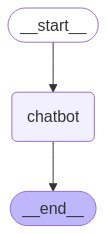

Goodbye!


In [ ]:
from typing import Annotated

from langchain_ollama import ChatOllama
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Graph Instance
graph_builder = StateGraph(State)

# Model
llm = ChatOllama(model="llama3.2:latest")


# Node
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break


Above is simople example of chatbot using LangGraph, Now we add tool in this chatbot. We're going to integrate search tool using Tavily.

Add TAVILY_API_KEY in env

In [3]:
_set_env("TAVILY_API_KEY")

Integrate Tavily with chatbot

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
# tool.invoke("What's a 'node' in LangGraph?")

[{'title': 'LangGraph - LangChain Blog',
  'url': 'https://blog.langchain.dev/langgraph/',
  'content': 'TL;DR: LangGraph is module built on top of LangChain to better enable creation of cyclical graphs, often needed for agent runtimes. This state is updated by nodes in the graph, which return operations to attributes of this state (in the form of a key-value store). After adding nodes, you can then add edges to create the graph. An example of this may be in the basic agent runtime, where we always want the model to be called after we call a tool. graph.add_edge("tools", "model") The state of this graph by default contains concepts that should be familiar to you if you\'ve used LangChain agents: input, chat_history, intermediate_steps (and agent_outcome to represent the most recent agent outcome)',
  'score': 0.70944256},
 {'title': 'LangGraph Glossary - GitHub Pages',
  'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': '[](https://langchain-ai.github.

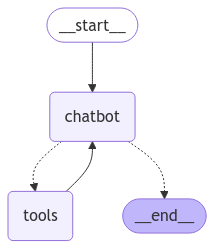

Assistant: 
Assistant: [{"title": "NBC News - Breaking News & Top Stories - Latest World, US ...", "url": "https://www.nbcnews.com/", "content": "FrequentSearches | Search Ads / [SPONSORED](https://popup.taboola.com/en/?template=colorbox&utm_source=nbcnews&utm_medium=referral&utm_content=thumbnails-feed-4x1:BelowHomepageThumbnails|Card2:)[SPONSORED](https://popup.taboola.com/en/?template=colorbox&utm_source=nbcnews&utm_medium=referral&utm_content=thumbnails-feed-4x1:BelowHomepageThumbnails|Card2:) New Electric Cars Come With Tiny Price Tags (Take A Look) SunValue / [SPONSORED](https://popup.taboola.com/en/?template=colorbox&utm_source=nbcnews&utm_medium=referral&utm_content=thumbnails-feed-4x1:BelowHomepageThumbnails|Card2:)[SPONSORED](https://popup.taboola.com/en/?template=colorbox&utm_source=nbcnews&utm_medium=referral&utm_content=thumbnails-feed-4x1:BelowHomepageThumbnails|Card2:) Power Bill Savings From Solar Panels Are Turning Heads In CaliforniaIf you pay more than $99/month for 

In [8]:
from typing import Annotated

from langchain_ollama import ChatOllama
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode, tools_condition



# Graph state
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Graph Instance
graph_builder = StateGraph(State)

# Model
llm = ChatOllama(model="llama3.2:latest")
llm_with_tools = llm.bind_tools(tools)

# Node
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()


try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        print("It seems your question is empty!")
        break